<a href="https://colab.research.google.com/github/MarcelLopes7/Machine-Learning---Analytics/blob/main/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Machine Learning & Analytics
## Autor: Marcel Antonio Lopes Pereira

## Introdução

Escrever introdução do trabalho

## Importação das bibliotecas

Com os atributos definidos, o código do programa inicia com a importação das bibliotecas python que serão utilizadas nesse projeto. A seguir, são definidas algumas funções que serão utilizadas ao longo do código.

In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import missingno as ms # para tratamento de missings
import math

## Transformações Numéricas
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.preprocessing import StandardScaler # para padronização

## Funções utilizadas no programa

Essa função é definida para remover colunas somente com variáveis do tipo string, caso seja necessário utilizar o dataset para realizar análises extritamente númericas, como na criação de uma matriz de correlação.

In [ ]:
# Função para remover colunas object
def remover_colunas_object(df):

    # Selecionar apenas colunas que não são do tipo 'object'
    df_numerico = df.select_dtypes(exclude=['object'])

    return df_numerico

Função para construir bloxplots de todas as colunas numéricas em subplots organizados.

In [ ]:
def boxplots(df_numerico, num_boxplots_por_linha=2,
             figsize=(12, 6), cor_paleta='viridis'):
    """
    Função para criar boxplots de todas as colunas numéricas em
    subplots organizados.

    Parâmetros:
    - df_numerico: DataFrame contendo apenas colunas numéricas.
    - num_boxplots_por_linha: Número de boxplots por linha
      (padrão é 2).
    - figsize: Tamanho base da figura (padrão é (12, 6)).
    - cor_paleta: Paleta de cores para os boxplots (padrão é
      'viridis').
    """
    # Número de colunas no dataframe
    num_colunas = df_numerico.shape[1]

    # Definir o número de linhas necessárias
    num_linhas = math.ceil(num_colunas / num_boxplots_por_linha)

    # Ajustar o tamanho da figura
    fig, axes = plt.subplots(
        nrows=num_linhas, ncols=num_boxplots_por_linha,
        figsize=(figsize[0], num_linhas * figsize[1])
    )

    # Flatten o array de eixos para simplificar a iteração
    axes = axes.flatten()

    # Definindo o estilo do Seaborn
    sns.set_theme(style="whitegrid")

    # Iterar sobre cada coluna do dataframe e criar um boxplot
    for i, col in enumerate(df_numerico.columns):
        sns.boxplot(x=df_numerico[col], ax=axes[i], palette=cor_paleta)
        axes[i].set_title(f'Boxplot da coluna: {col}', fontsize=12)
        axes[i].set_xlabel('')  # Remover o rótulo do eixo x
        axes[i].set_ylabel('Valores', fontsize=10)
        axes[i].grid(True)  # Adiciona grid para melhor visualização

    # Remover eixos não usados, se houver
    if num_colunas % num_boxplots_por_linha != 0:
        for j in range(num_colunas, len(axes)):
            fig.delaxes(axes[j])

    # Ajustar o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

## Análise Exploratória e Preparação dos Dados



In [ ]:
# URL de importação do dataset
url = (
    "https://raw.githubusercontent.com/MarcelLopes7/"
    "Machine-Learning---Analytics/refs/heads/main/"
    "gym_members_exercise_tracking.csv"
)

# Leitura do arquivo
dataset = pd.read_csv(url)

# Visualização de todas as colunas do dataframe
pd.set_option(
    'display.max_columns', None
)

In [ ]:
# Exibição das primeiras linhas do dataset
dataset.head(10)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
5,56,Female,58.0,1.68,168,156,74,1.59,1116.0,HIIT,15.5,2.7,5,3,20.55
6,36,Male,70.3,1.72,174,169,73,1.49,1385.0,Cardio,21.3,2.3,3,2,23.76
7,40,Female,69.7,1.51,189,141,64,1.27,895.0,Cardio,30.6,1.9,3,2,30.57
8,28,Male,121.7,1.94,185,127,52,1.03,719.0,Strength,28.9,2.6,4,2,32.34
9,28,Male,101.8,1.84,169,136,64,1.08,808.0,Cardio,29.7,2.7,3,1,30.07


In [ ]:
# Mostra as dimensões do dataframe
dataset.shape

(973, 15)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [ ]:
# Resumo estatístico do dataframe
dataset.describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,24.976773,2.626619,3.321686,1.809866,24.912127
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,6.259419,0.600172,0.913047,0.739693,6.660879
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.320000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,3.000000,1.000000,20.110000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,26.200000,2.600000,3.000000,2.000000,24.160000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,29.300000,3.100000,4.000000,2.000000,28.560000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,49.840000


In [ ]:
# Criando um novo dataframe com as colunas númericas
df_numerico = remover_colunas_object(dataset)

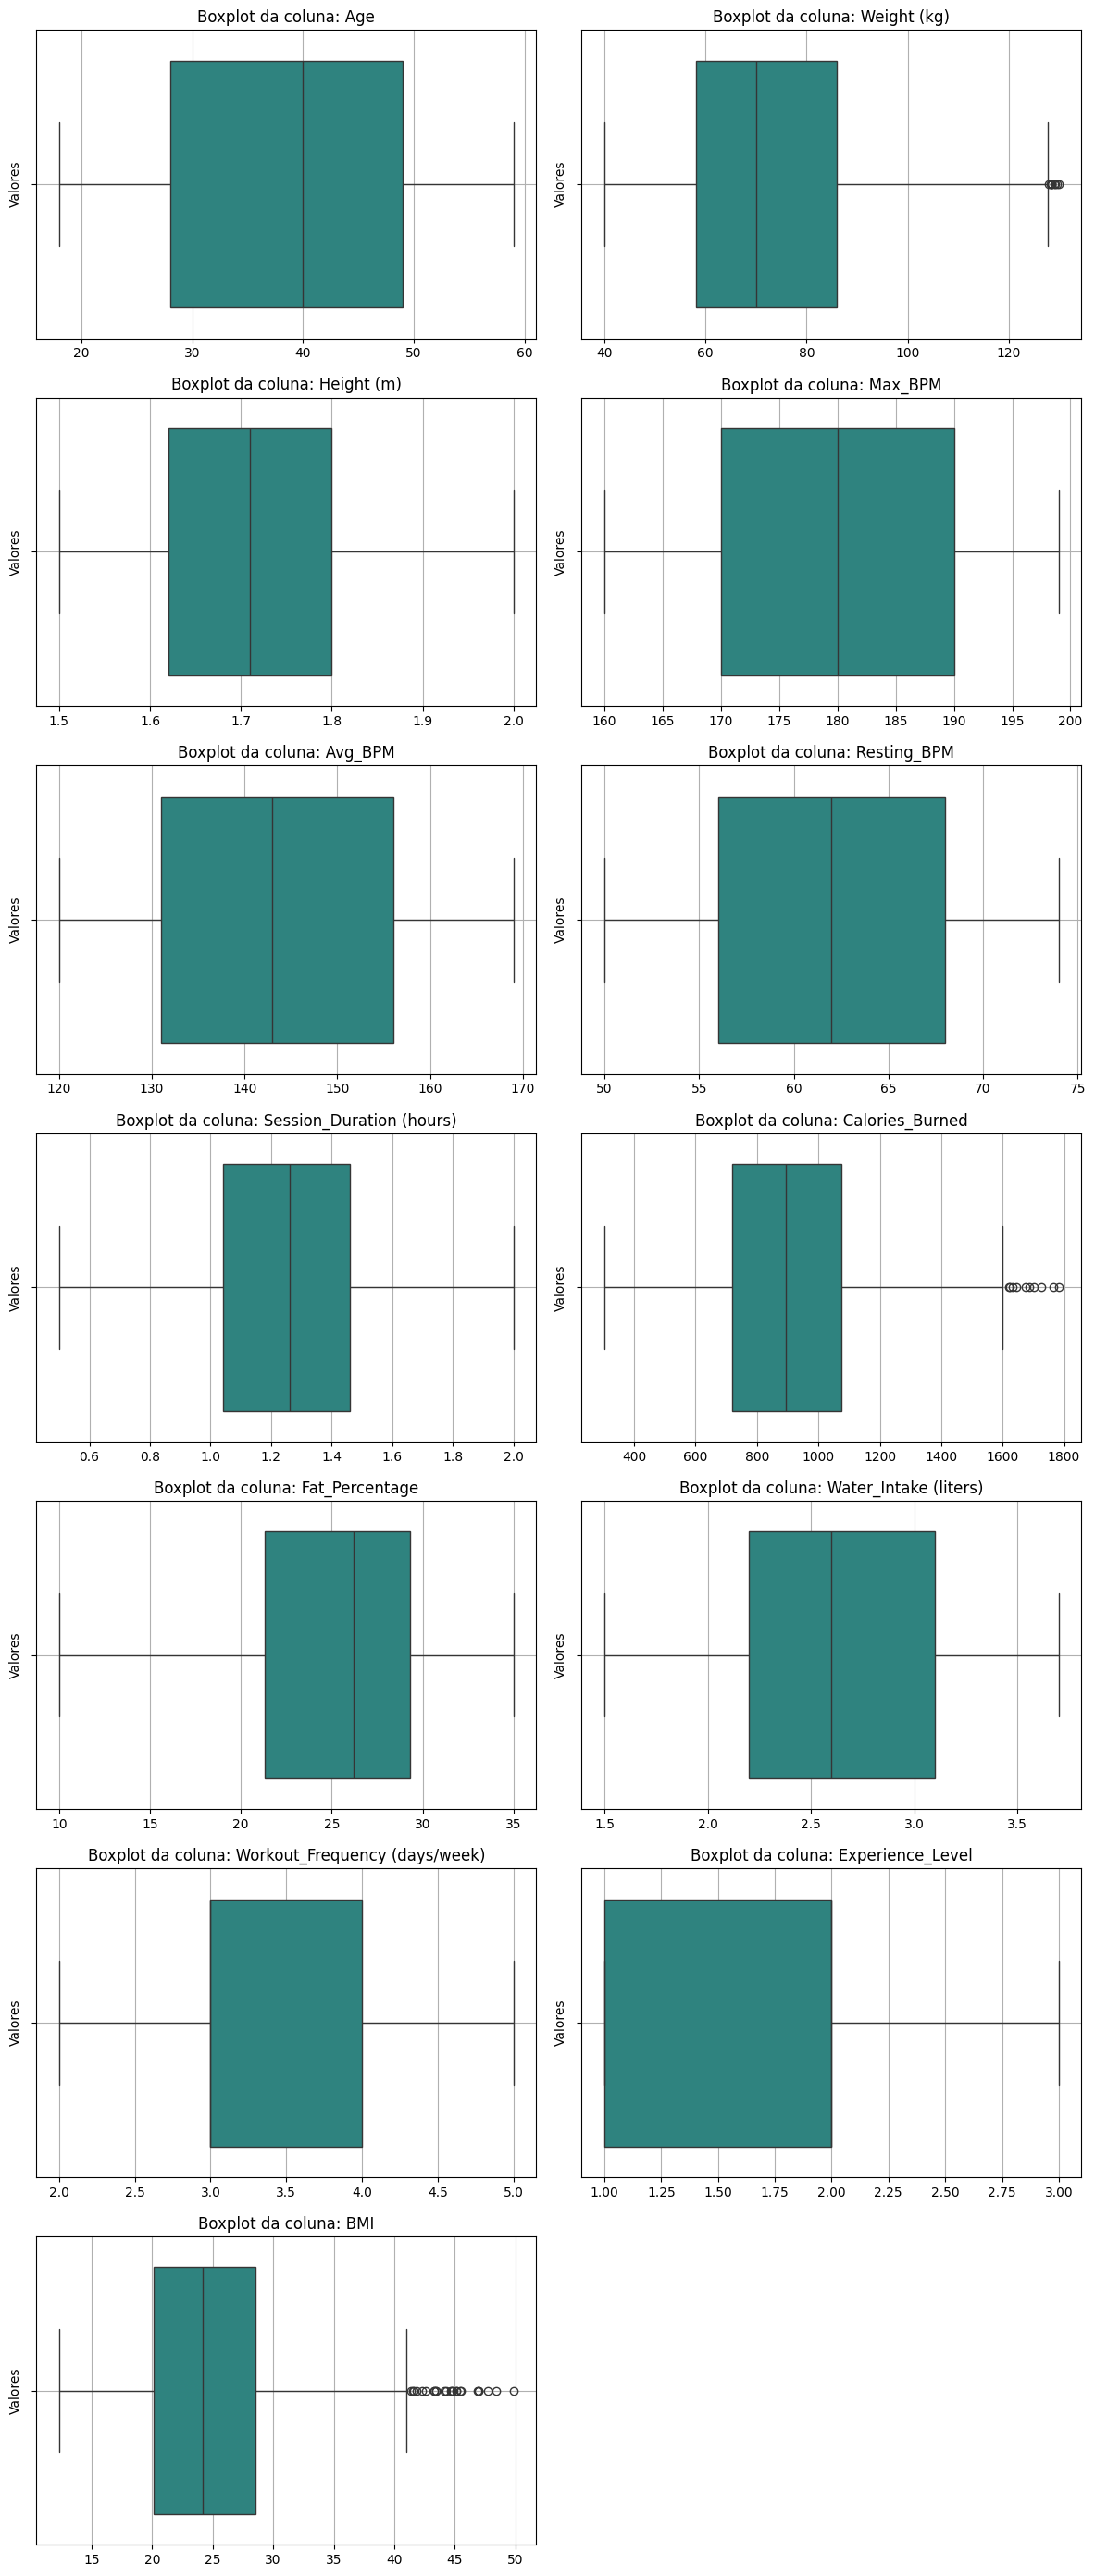

In [ ]:
# Chamada da função para plotar os boxplots
boxplots(df_numerico, 2, (12,4))

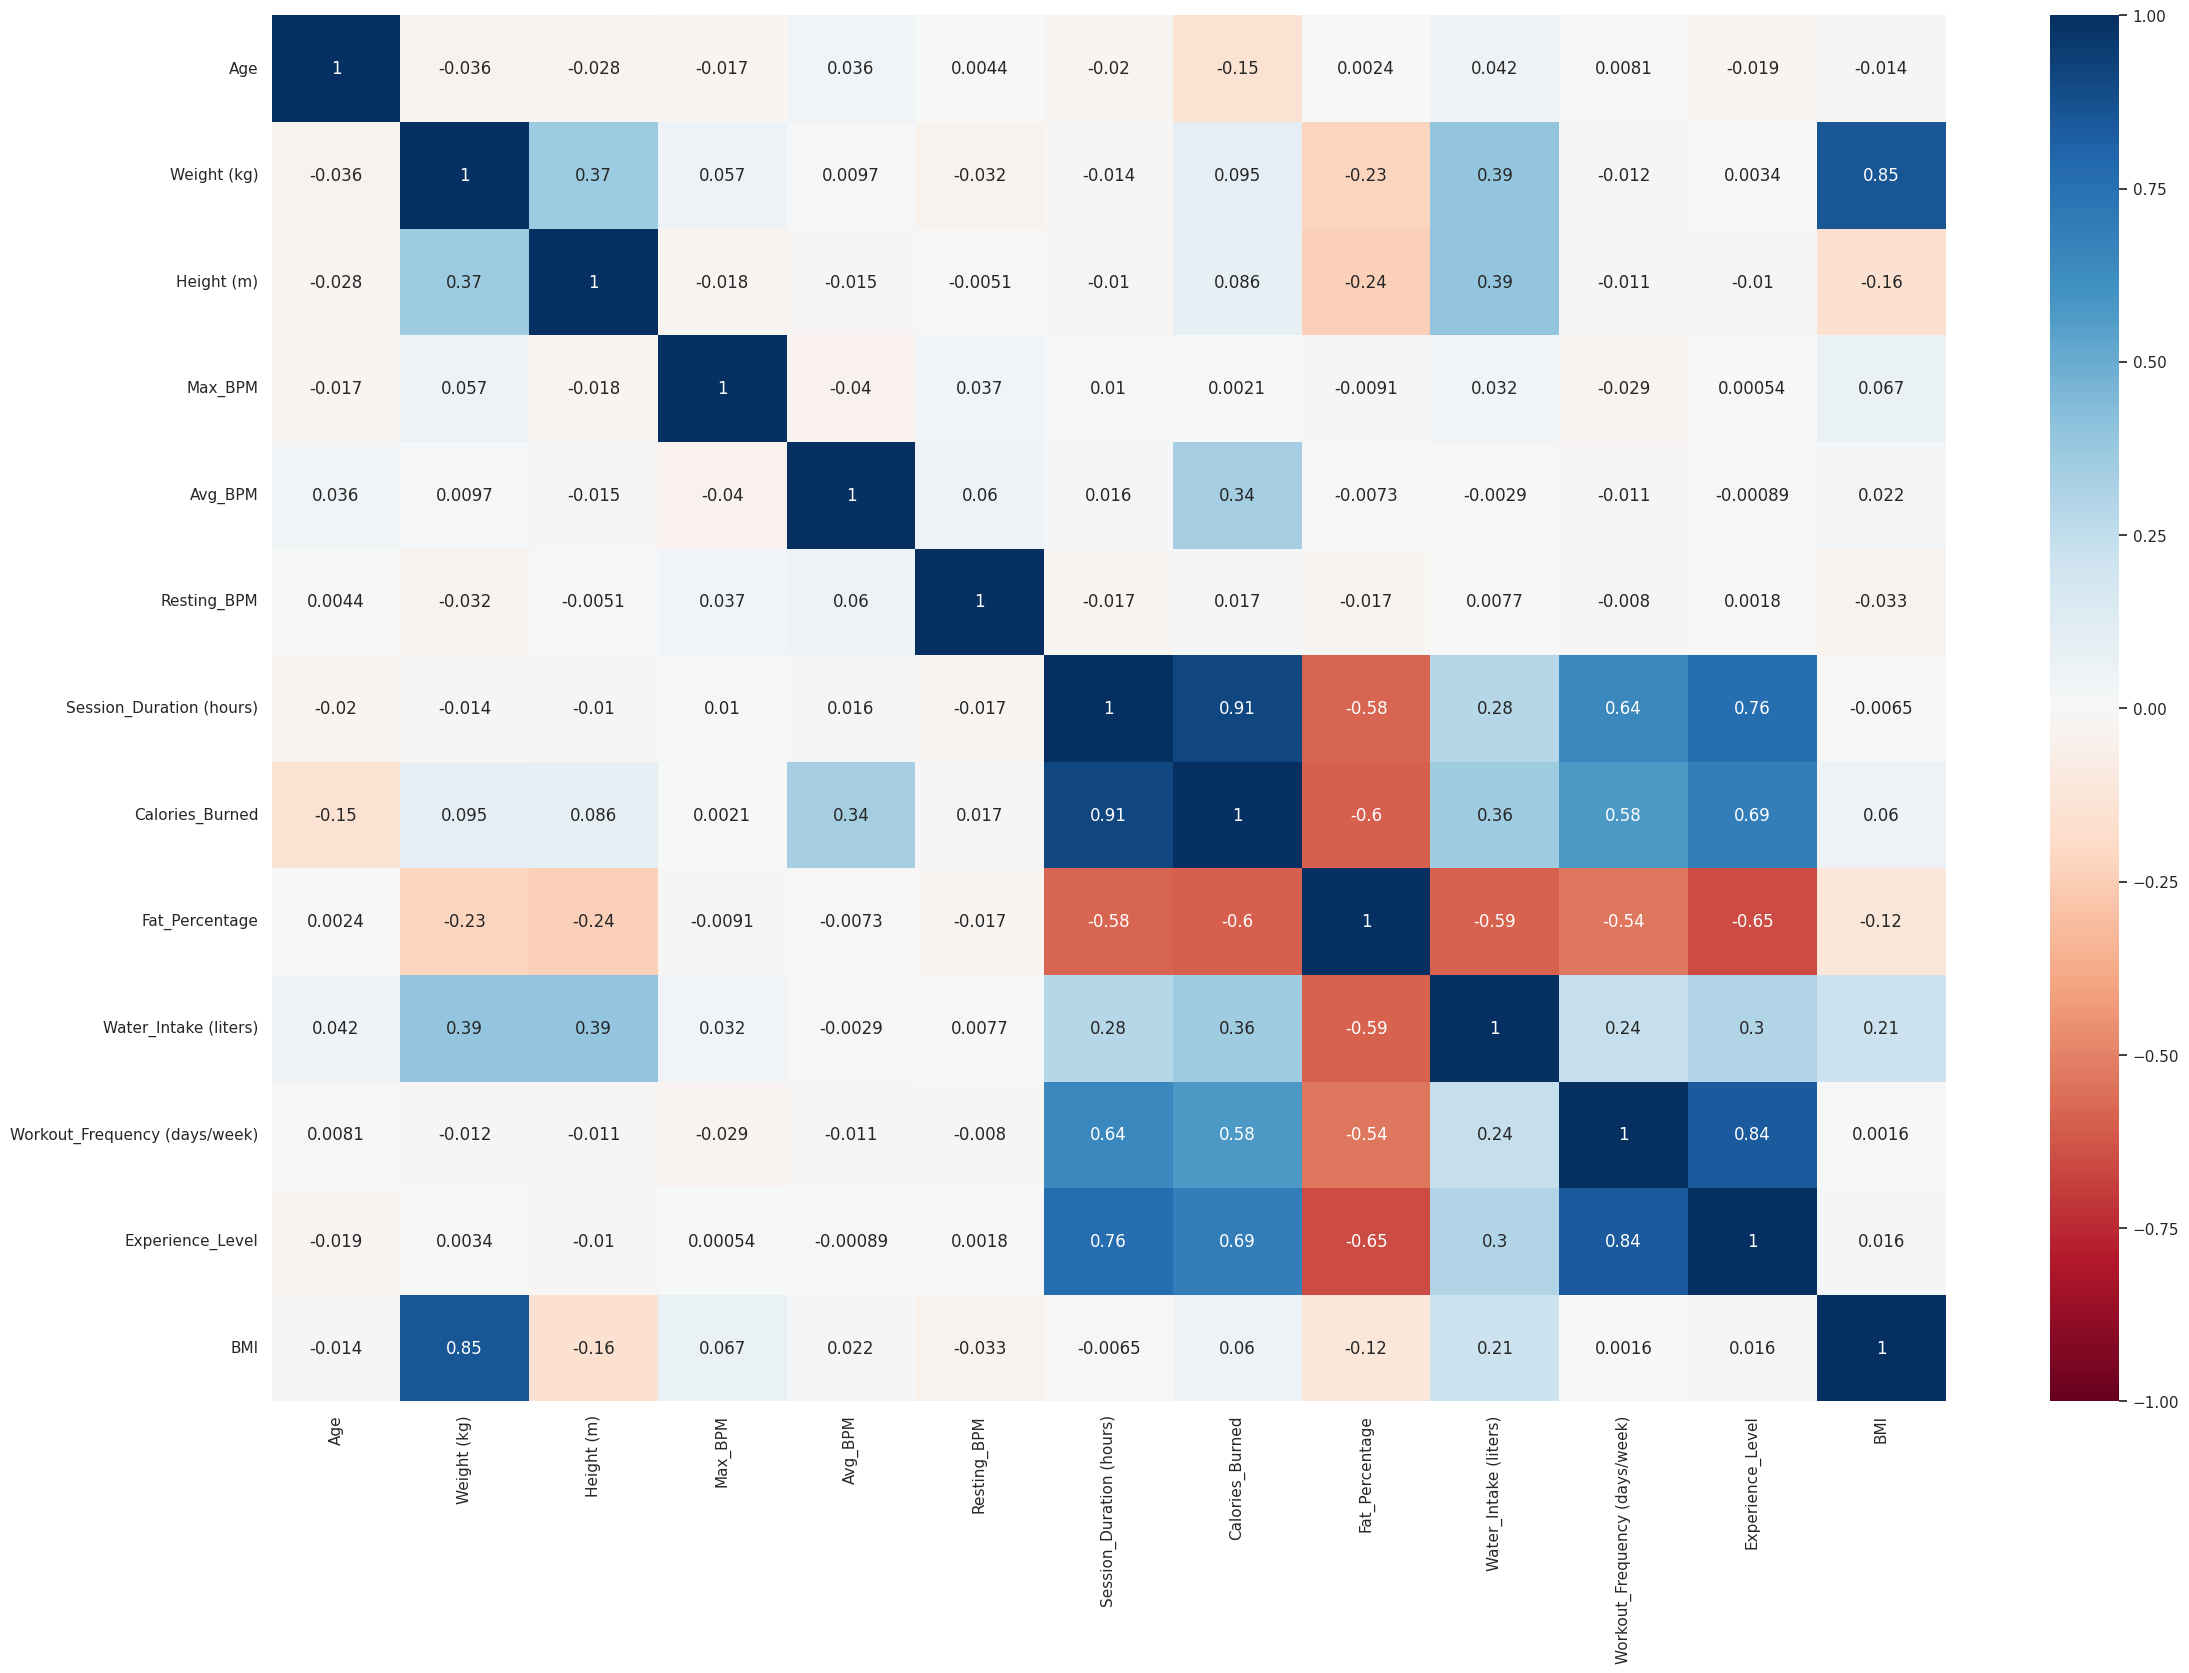

In [ ]:
# Gerando a matriz de correlação de Pearson
plt.figure(figsize = (27,18))
sns.heatmap(df_numerico.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);